In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
data = pd.read_csv('./data/final_data.csv')
# data.columns = ["user_id", "game_title", "behavior_name", "value", "x"]
data.head()

,user_id,game_title,ratings,appid
0,151603712,The Elder Scrolls V: Skyrim,6,72850.0
1,151603712,Fallout 4,5,377160.0
2,151603712,Spore,4,17390.0
3,151603712,Fallout: New Vegas,4,22449.0
4,151603712,Left 4 Dead 2,4,550.0


In [8]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
data = data.drop_duplicates()
data.head()

,user_id,game_title,ratings,appid
0,151603712,The Elder Scrolls V: Skyrim,6,72850.0
1,151603712,Fallout 4,5,377160.0
2,151603712,Spore,4,17390.0
3,151603712,Fallout: New Vegas,4,22449.0
4,151603712,Left 4 Dead 2,4,550.0


In [ ]:
data_games_group = data.groupby('game_title')
data_games_group.first()


In [ ]:
data['value'].describe()

In [ ]:
%matplotlib inline
data[data['value'] != 1.0]['value'].hist(bins=1000)

In [ ]:
_, bins, _ = plt.hist(data[data['value'] != 1.0]['value'])
bins

In [ ]:
data[np.logical_and(data.value != 1.0, data.value < 200)]['value'].hist()

In [ ]:
data[np.logical_and(data.value != 1.0, data.value < 25)]['value'].hist()

In [ ]:
purchased = data[data['behavior_name'] == 'purchase']
purchased.loc[:, ['value']] = 1

played = data[data['behavior_name'] != 'purchase']
def convert_data_to_rating(value):
    if value > 1000:
        return 7
    if value > 200:
        return  6
    if value > 20:
        return 5
    if value > 5:
        return 4
    if value > 1:
        return 3
    return 2
played.loc[:, ['value']] = played['value'].map(convert_data_to_rating)
played['value'].append(purchased['value']).sort_index()

In [ ]:
data_group_behaviour = data.copy()
data_group_behaviour['ratings'] = played['value'].append(purchased['value']).sort_index()

In [ ]:
data_group_behaviour


In [ ]:
data_group_behaviour.loc[:, ['user_id', 'game_title']].duplicated()

In [ ]:
sorted_d = data_group_behaviour.sort_values(by=['user_id', 'game_title', 'behavior_name'])

In [ ]:
data.sort_values(by=['behavior_name'])[data_group_behaviour.sort_values(by=['behavior_name']).loc[:, ['user_id', 'game_title']].duplicated()]

In [ ]:
data_group_behaviour[np.logical_and(data_group_behaviour.user_id == 228908339, data_group_behaviour.game_title == 'Grand Theft Auto V')]

In [ ]:
purchased_played = sorted_d[sorted_d.loc[:, ['user_id', 'game_title']].duplicated()]

In [ ]:
final_data = pd.concat([data_group_behaviour, purchased_played]).drop_duplicates(keep=False)

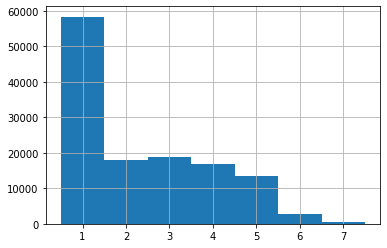

In [80]:
final_data['ratings'].hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])

In [15]:
game_features = final_data.pivot(
    index='game_title',
    columns='user_id',
    values='ratings'
).fillna(0)

from scipy.sparse import csr_matrix
game_features_matrix = csr_matrix(game_features.values)
game_features_matrix

ValueError: Index contains duplicate entries, cannot reshape

In [83]:
hashmap = {
            game: i for i, game in
            enumerate(list(final_data.set_index('game_title').loc[game_features.index]['game_title'])) # noqa
        }
hashmap

KeyError: 'game_title'

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(game_features_matrix)

In [129]:
from fuzzywuzzy import fuzz
game = 'fallout'
matches = []
all_games = game_features.index.values
for c_game in all_games:
    ratio = fuzz.ratio(game.lower(), c_game.lower())
    if ratio >= 60:
        matches.append((c_game, ratio))
        # break
# if len(matches)>1:
match_tuple = sorted(matches, key=lambda x: x[1])[::-1]
if not match_tuple:
    print('Oops! No match is found')
else:
    print('Found possible matches in our database: '
                      '{0}\n'.format([x[0] for x in match_tuple]))
    match = match_tuple[0][0]


Found possible matches in our database: ['Fallout', 'Fallout 4', 'Fallout 3', 'Fallout 2', 'FlatOut', 'Fallout Tactics', 'Call of Duty', 'Flatout 3', 'FlatOut 2']



In [130]:
n_recommendations = 10
idx = game_features.index.get_loc(match)
distances, indices = model_knn.kneighbors(
            game_features_matrix[idx],
            n_neighbors=n_recommendations+1)
raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )[:0:-1]

In [131]:
for i, (idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, with distance '
                  'of {2}'.format(i+1, game_features.index[idx], dist))

1: STAR WARS X-Wing Special Edition, with distance of 0.7663175048652056
2: Fallout New Vegas Dead Money, with distance of 0.7533723552650654
3: Fallout New Vegas Honest Hearts, with distance of 0.7533723552650654
4: Wasteland 2, with distance of 0.7462409103914487
5: Wasteland 2 Director's Cut, with distance of 0.734641854820958
6: Silverfall, with distance of 0.7181683067504858
7: Rigonauts, with distance of 0.707896881081507
8: Distant Worlds Universe, with distance of 0.707896881081507
9: Fallout Tactics, with distance of 0.39939896834929367
10: Fallout 2, with distance of 0.2638426257837877


In [10]:
data.to_csv('./data/final_data.csv', index=None)



In [4]:
final_data = data.copy()
final_data.head()

,user_id,game_title,ratings,appid
0,151603712,The Elder Scrolls V: Skyrim,6,72850.0
1,151603712,Fallout 4,5,377160.0
2,151603712,Spore,4,17390.0
3,151603712,Fallout: New Vegas,4,22449.0
4,151603712,Left 4 Dead 2,4,550.0


In [17]:
game_features = final_data[['game_title', 'user_id', 'ratings']].pivot(
    index='game_title',
    columns='user_id',
    values='ratings'
).fillna(0)

ValueError: Index contains duplicate entries, cannot reshape

In [8]:
game_features = final_data[['game_title', 'user_id', 'ratings']]
game_features[game_features.duplicated()]


,game_title,user_id,ratings
18,Grand Theft Auto IV,151603712,2
19,Grand Theft Auto IV,151603712,2
25,BioShock,151603712,2
32,Fallen Earth,151603712,1
49,Sid Meier's Civilization V,59945701,5
...,...,...,...
134892,TERA,88705345,3
134932,Grand Theft Auto V,99096740,5
134949,Crysis,99096740,4
134982,Fallen Earth,128470551,3


In [11]:
data_p = pd.read_csv('./data/steam-processed.csv')
data_p.head()

,Unnamed: 0,user_id,game_title,ratings
0,1,151603712,The Elder Scrolls V Skyrim,6
1,3,151603712,Fallout 4,5
2,5,151603712,Spore,4
3,7,151603712,Fallout New Vegas,4
4,9,151603712,Left 4 Dead 2,4
